In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
flight_data = pd.read_csv('FlightDelays.csv')

In [32]:
flight_data.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime


<font size = 3>**We can see that in this dataset, except for the DISTANCE column, which represents the distance of the flight and is a numerical data, the data in other columns are essentially data representing categories (we will see later that DISTANCE data, as an important predictor, can also be classified); so we will try to apply different classifier algorithms to try to predict flight status and compare the performance of these models.**

<font size = 3>**First, we preprocessed the data set to make the classification of each predictor clearer and to remove some irrelevant predictors that may interfere, such as TAIL_NUM.**

In [33]:
# Split CRS_DEP_TIME and DEP_TIME to hour and minute columns
flight_data[['CRS_DEP_HOUR', 'CRS_DEP_MIN']] = flight_data['CRS_DEP_TIME'].apply(lambda x: pd.Series(divmod(int(x), 100)))
#flight_data[['DEP_HOUR', 'DEP_MIN']] = flight_data['DEP_TIME'].apply(lambda x: pd.Series(divmod(int(x), 100)))

# Round DISTANCE column to the nearest hundred
flight_data['DISTANCE'] = flight_data['DISTANCE'].apply(lambda x: round(x, -1))

# Extract month from FL_DATE
'''flight_data['FL_DATE'] = pd.to_datetime(flight_data['FL_DATE'])
flight_data['MONTH'] = flight_data['FL_DATE'].dt.month'''

# Map Flight Status to 0 and 1
flight_data['FLIGHT_STATUS'] = flight_data['Flight Status'].map({'ontime': 0, 'delayed': 1})

# Drop the original columns that have been split or mapped
flight_data.drop(columns=['CRS_DEP_TIME', 'DEP_TIME', 'FL_NUM', 'FL_DATE', 'TAIL_NUM', 'Flight Status'], axis=1, inplace=True)

# Display the first few rows of the cleaned dataset
flight_data.head()

,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,CRS_DEP_HOUR,CRS_DEP_MIN,FLIGHT_STATUS
0,OH,JFK,180,BWI,0,4,1,14,55,0
1,DH,JFK,210,DCA,0,4,1,16,40,0
2,DH,LGA,230,IAD,0,4,1,12,45,0
3,DH,LGA,230,IAD,0,4,1,17,15,0
4,DH,LGA,230,IAD,0,4,1,10,39,0


In [34]:
# Rearrange cols
#cols = ['CRS_DEP_HOUR', 'CRS_DEP_MIN', 'CARRIER', 'DEP_HOUR', 'DEP_MIN', 'DEST', 'DISTANCE', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'FLIGHT_STATUS']
cols = ['CRS_DEP_HOUR', 'CRS_DEP_MIN', 'CARRIER', 'DEST', 'DISTANCE', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'FLIGHT_STATUS']
flight_data = flight_data[cols]
flight_data

,CRS_DEP_HOUR,CRS_DEP_MIN,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,FLIGHT_STATUS
0,14,55,OH,JFK,180,BWI,0,4,1,0
1,16,40,DH,JFK,210,DCA,0,4,1,0
2,12,45,DH,LGA,230,IAD,0,4,1,0
3,17,15,DH,LGA,230,IAD,0,4,1,0
4,10,39,DH,LGA,230,IAD,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...
2196,6,45,RU,EWR,200,DCA,0,6,31,0
2197,17,0,RU,EWR,210,IAD,0,6,31,0
2198,16,0,RU,EWR,200,DCA,0,6,31,0
2199,13,59,RU,EWR,200,DCA,0,6,31,0


In [35]:
flight_data.describe()

,CRS_DEP_HOUR,CRS_DEP_MIN,DISTANCE,Weather,DAY_WEEK,DAY_OF_MONTH,FLIGHT_STATUS
count,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000,2201.000000
mean,13.516129,20.325761,209.900045,0.014539,3.905498,16.024989,0.194457
std,4.349696,18.976653,13.371918,0.119725,1.903149,8.677390,0.395872
min,6.000000,0.000000,170.000000,0.000000,1.000000,1.000000,0.000000
25%,10.000000,0.000000,210.000000,0.000000,2.000000,8.000000,0.000000
50%,14.000000,20.000000,210.000000,0.000000,4.000000,16.000000,0.000000
75%,17.000000,30.000000,210.000000,0.000000,5.000000,23.000000,0.000000
max,21.000000,59.000000,230.000000,1.000000,7.000000,31.000000,1.000000


<font size = 3>**Next, we will use some data visualization to gain a more intuitive understanding of this dataset.**

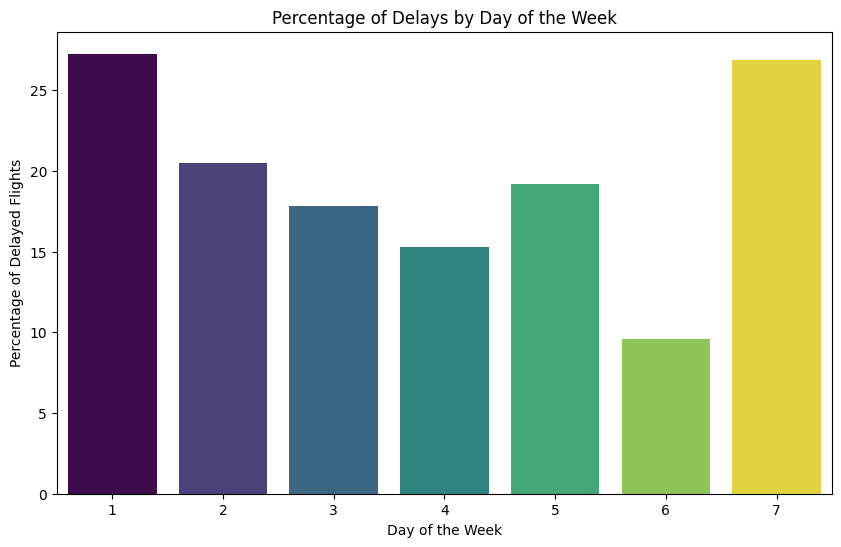

In [36]:
# Calculate the percentage of delays per day of the week
total_flights_by_day = flight_data.groupby('DAY_WEEK').size()
delayed_flights_by_day = flight_data[flight_data['FLIGHT_STATUS'] == 1].groupby('DAY_WEEK').size()

percentage_delay_by_day = (delayed_flights_by_day / total_flights_by_day) * 100

# Create a DataFrame for plotting
percentage_delay_by_day_df = percentage_delay_by_day.reset_index()
percentage_delay_by_day_df.columns = ['DAY_WEEK', 'Percentage_Delay']

# Plotting the percentage of delays by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='DAY_WEEK', y='Percentage_Delay', hue='DAY_WEEK', data=percentage_delay_by_day_df, palette='viridis', dodge=False)
plt.title('Percentage of Delays by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage of Delayed Flights')
plt.legend([], [], frameon=False)
plt.show()


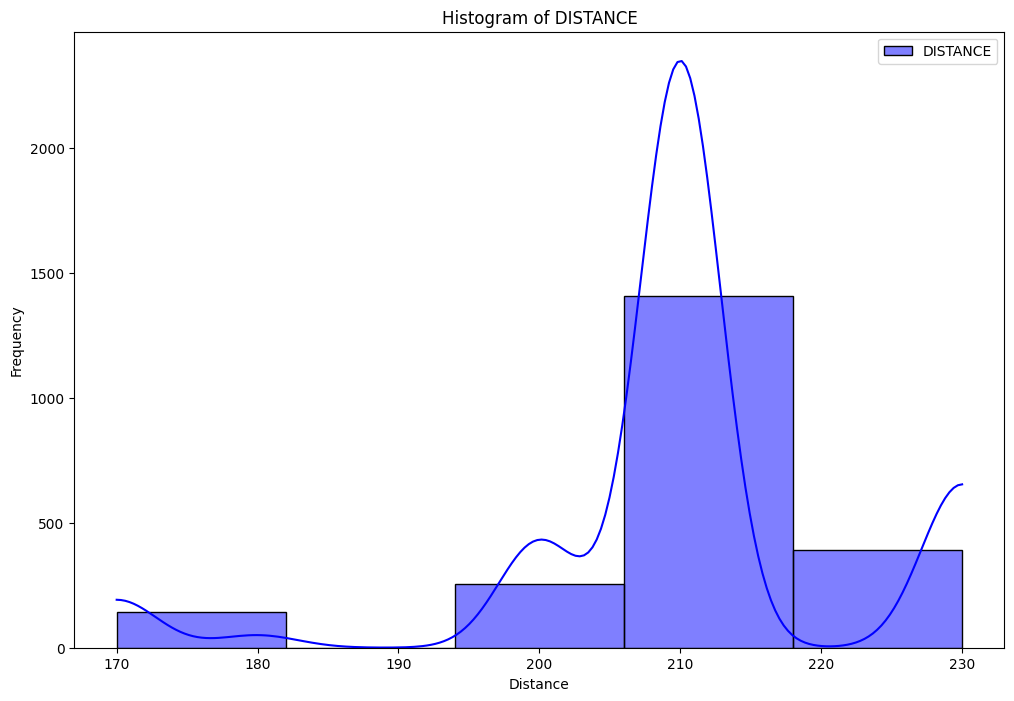

In [37]:
# Histogram of DISTANCE
plt.figure(figsize=(12, 8))

# Plot for on-time flights
sns.histplot(flight_data['DISTANCE'], color='blue', label='DISTANCE', kde=True, bins=5)


plt.title('Histogram of DISTANCE')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

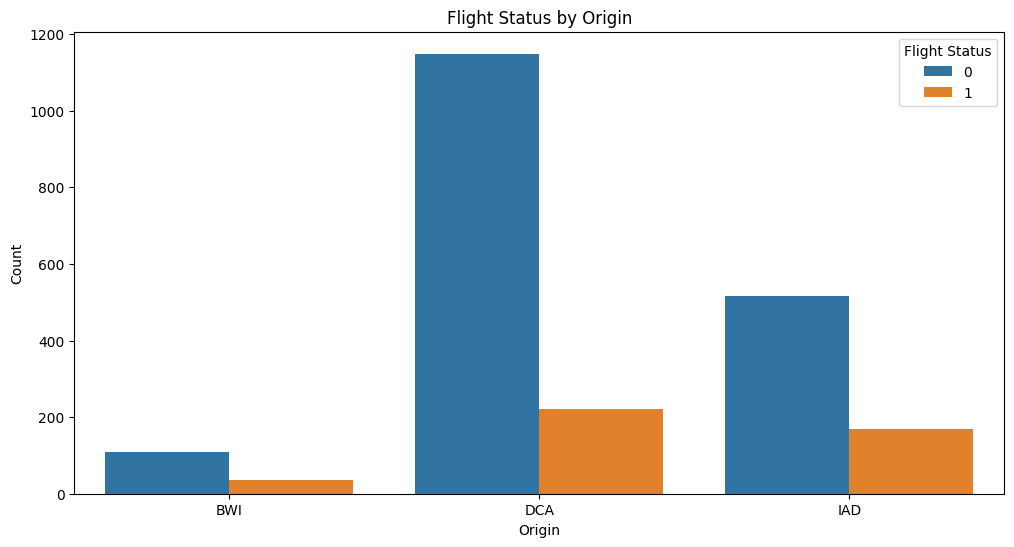

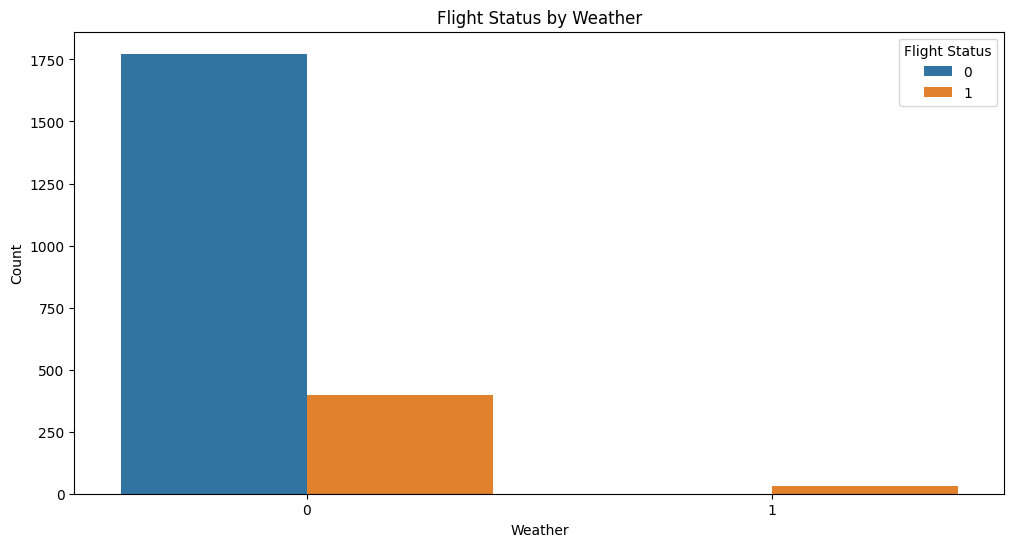

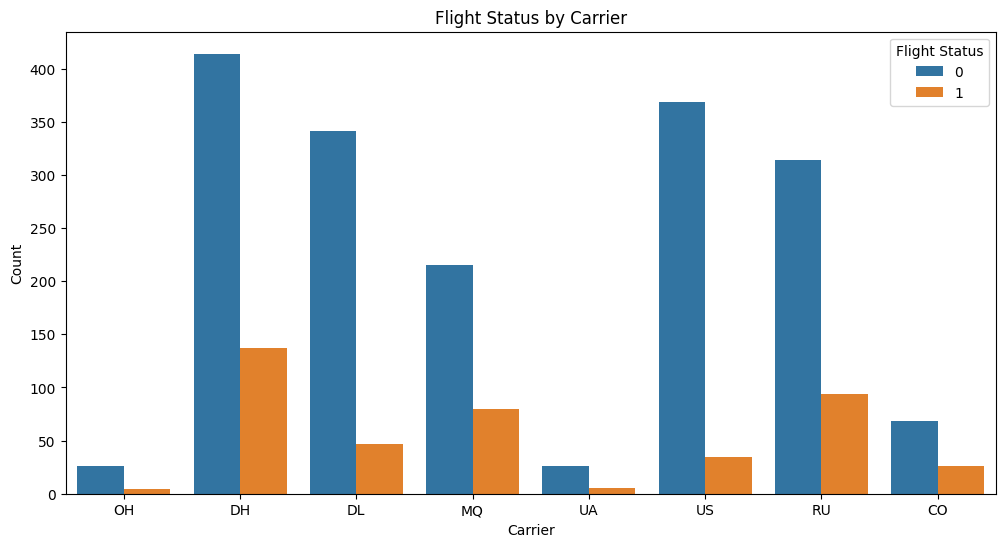

In [40]:
plt.figure(figsize=(12, 6))
sns.countplot(x='ORIGIN', hue='FLIGHT_STATUS', data=flight_data)
plt.title('Flight Status by Origin')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.legend(title='Flight Status')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Weather', hue='FLIGHT_STATUS', data=flight_data)
plt.title('Flight Status by Weather')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.legend(title='Flight Status')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='CARRIER', hue='FLIGHT_STATUS', data=flight_data)
plt.title('Flight Status by Carrier')
plt.xlabel('Carrier')
plt.ylabel('Count')
plt.legend(title='Flight Status')
plt.show()

<font size = 3>**Next, we do the final processing of the dataset before training. We perform label encoding on the categorical columns to convert the categorical values into integer values so that the model can process this data.**

In [41]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['CARRIER', 'DEST', 'ORIGIN']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    flight_data[column] = label_encoders[column].fit_transform(flight_data[column])

flight_data

,CRS_DEP_HOUR,CRS_DEP_MIN,CARRIER,DEST,DISTANCE,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,FLIGHT_STATUS
0,14,55,4,1,180,0,0,4,1,0
1,16,40,1,1,210,1,0,4,1,0
2,12,45,1,2,230,2,0,4,1,0
3,17,15,1,2,230,2,0,4,1,0
4,10,39,1,2,230,2,0,4,1,0
...,...,...,...,...,...,...,...,...,...,...
2196,6,45,5,0,200,1,0,6,31,0
2197,17,0,5,0,210,2,0,6,31,0
2198,16,0,5,0,200,1,0,6,31,0
2199,13,59,5,0,200,1,0,6,31,0


<font size = 3>**We select 80% of the data set as the training set and then standardize them.**

In [42]:
# Define features and target variable
X = flight_data.drop(['FLIGHT_STATUS'], axis=1)
y = flight_data['FLIGHT_STATUS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<font size = 5>**KNN Classifier**

<font size = 3>**First, we train different numbers of neighbors and get the F1 score of each corresponding model. The F1 score is an evaluation indicator that combines precision and recall, and is mainly used for performance evaluation of classification problems.**

In [43]:
# Initialize lists to store results
neighbors_values = range(2, 21)
accuracies = []

# Loop through different values of n_neighbors
for k in neighbors_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = f1_score(y_test, y_pred)
    accuracies.append(round(accuracy,3))

# Create and display the results in a DataFrame format
results_df = pd.DataFrame({
    'Number of Neighbors (k)': neighbors_values,
    'F1-Score (Standardized Data)': accuracies
})
results_df

,Number of Neighbors (k),F1-Score (Standardized Data)
0,2,0.237
1,3,0.286
2,4,0.224
3,5,0.281
4,6,0.235
5,7,0.275
6,8,0.206
7,9,0.248
8,10,0.189
9,11,0.218


<font size = 3>**Then, we used the model with the maximum f1 score (k=3) to predict the test set and generate a Classification Report. At the same time, we used the Permutation Importance method to calculate the feature importance. Specifically, it shows the importance of each feature on the model performance.**

<font size = 3>**From the classification report, we can see that the overall f1_score of the model is 0.286; because our prediction result is a binary classification case, that is, there are only two cases, 0 and 1, the comprehensive f1_score defaults to 0.29 when FLIGHT_STATUS=1 (delayed), which is a poor performance; but when predicting FLIGHT_STATUS=0 (on time), the performance is relatively good (f1 score is 0.87). From the bar chart, we can see that the CARRIER predictor is the most important feature and has the greatest impact on model performance. Weather is also a very important feature that has a significant impact on model performance. Distance has the least impact on model performance, and may even have a negative impact, indicating that this feature does not play a big role in the model.**

f1_score: 0.2857142857142857
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       357
           1       0.36      0.24      0.29        84

    accuracy                           0.77       441
   macro avg       0.60      0.57      0.58       441
weighted avg       0.74      0.77      0.75       441



<Figure size 1000x600 with 0 Axes>

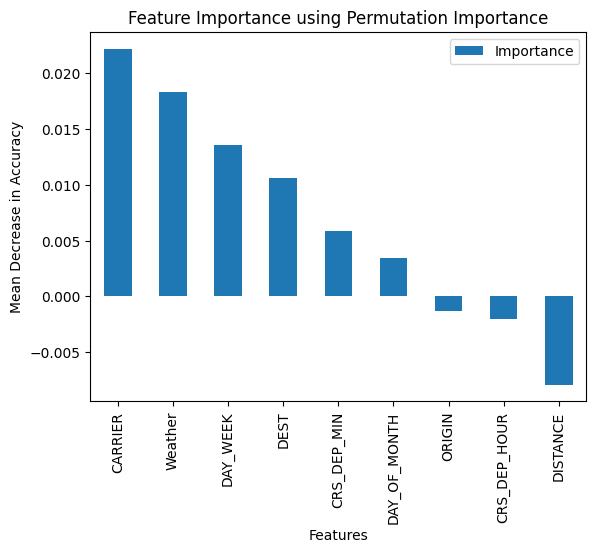

In [44]:
# Find the Number of Neighbors (k) where the F1-Score (Standardized Data) is max
max_accuracy_k = results_df.loc[results_df['F1-Score (Standardized Data)'].idxmax(), 'Number of Neighbors (k)']
max_accuracy_k

# Initialize the KNN model with the optimal number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=max_accuracy_k)

# Train the model
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
f1_knn = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(f'f1_score: {f1_knn}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Compute permutation feature importance
result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=1)

# Plot feature importance
importance_df = pd.DataFrame(result.importances_mean, index=X.columns, columns=['Importance']).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df.plot(kind='bar')
plt.title('Feature Importance using Permutation Importance')
plt.ylabel('Mean Decrease in Accuracy')
plt.xlabel('Features')
plt.show()

<font size = 5>**Logistic Regression**

<font size = 3>**Logistic regression is a statistical model widely used for classification tasks. Despite the word "regression" in its name, logistic regression is actually a classification method whose main purpose is to predict the probability of an event occurring.**

<font size = 3>**We directly use Logistic Regression to train the training set, apply it to the test set to obtain the prediction results, and generate a Classification Report.**

<font size = 3>**Similar to the Classification Report of the KNN classifier, from this classification report we can see that the f1_score is 0.11 when FLIGHT_STATUS=1 (delayed), which is a poor performance; but the performance is relatively good (f1 score is 0.9) when predicting FLIGHT_STATUS=0 (on time).**

In [45]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
f1_log_reg = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'f1_score: {f1_log_reg}')
print('Classification Report:')
print(report)

f1_score: 0.11235955056179775
Classification Report:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       357
           1       1.00      0.06      0.11        84

    accuracy                           0.82       441
   macro avg       0.91      0.53      0.51       441
weighted avg       0.85      0.82      0.75       441



<font size = 5>**Random Forest Classifier**

<font size = 3>**Random Forest Classifier is an ensemble learning method for classification and regression tasks. It improves the accuracy and robustness of the model by building multiple decision trees and combining their predictions.**

<font size = 3>**We directly use Random Forest Classifier to train the training set, apply it to the test set to obtain the prediction results, and generate a Classification Report.**

<font size = 3>**The Random Forest Classifier has improved its prediction accuracy a little when FLIGHT_STATUS=1 (delayed), with an f1_score of 0.36. It is still accurate when predicting FLIGHT_STATUS=0 (on time), with an f1_score of 0.89.**

In [46]:
# Initialize the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict the test set
y_pred = rf.predict(X_test)

# Evaluate the model
f1_rf = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'f1_score: {f1_rf}')
print('Classification Report:')
print(report)

f1_score: 0.359375
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89       357
           1       0.52      0.27      0.36        84

    accuracy                           0.81       441
   macro avg       0.68      0.61      0.63       441
weighted avg       0.78      0.81      0.79       441



<font size = 5>**XGBoost Classifier**

<font size = 3>**XGBoost Classifier is a powerful and flexible machine learning algorithm suitable for a variety of classification and regression tasks. By effectively utilizing gradient boosting techniques, regularization, and parallel processing, XGBoost is able to perform well on a variety of complex datasets.**

<font size = 3>**We directly use XGBoost Classifier to train the training set, apply it to the test set to obtain the prediction results, and generate a Classification Report.**

<font size = 3>**From the report, we can see that XGBoost Classifier has further improved its prediction accuracy when FLIGHT_STATUS=1 (delayed), with an f1_score of 0.49; and still has good accuracy when predicting FLIGHT_STATUS=0 (on time), with an f1_score of 0.9.**

In [47]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict the test set
y_pred = xgb_model.predict(X_test)

# Compute F1 Score
f1_xgb = f1_score(y_test, y_pred)

# Display F1 Score
report = classification_report(y_test, y_pred)

print(f'f1_score: {f1_xgb}')
print('Classification Report:')
print(report)

f1_score: 0.48951048951048953
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       357
           1       0.59      0.42      0.49        84

    accuracy                           0.83       441
   macro avg       0.73      0.67      0.70       441
weighted avg       0.82      0.83      0.82       441



<font size = 3>**Finally, we evaluate and visualize the F1 scores of the four algorithms. As you can see:**

<font size = 3>**XGBoost performs best: It is significantly ahead of other algorithms in F1 score, indicating that it has strong ability to handle complex data and feature interactions.**

<font size = 3>**Random Forest performs second best: Although not as good as XGBoost, Random Forest still performs much better than Logistic Regression and KNN, showing the advantages of ensemble learning methods.**

<font size = 3>**KNN performs moderately: KNN performs better than Logistic Regression, but lower than Random Forest and XGBoost. KNN is sensitive to noise and high-dimensional data, which may be the reason for its poor performance.**

<font size = 3>**Logistic Regression performs worst: It does not perform well on this dataset, probably because the data has strong nonlinear relationships, which Logistic Regression cannot capture well.**

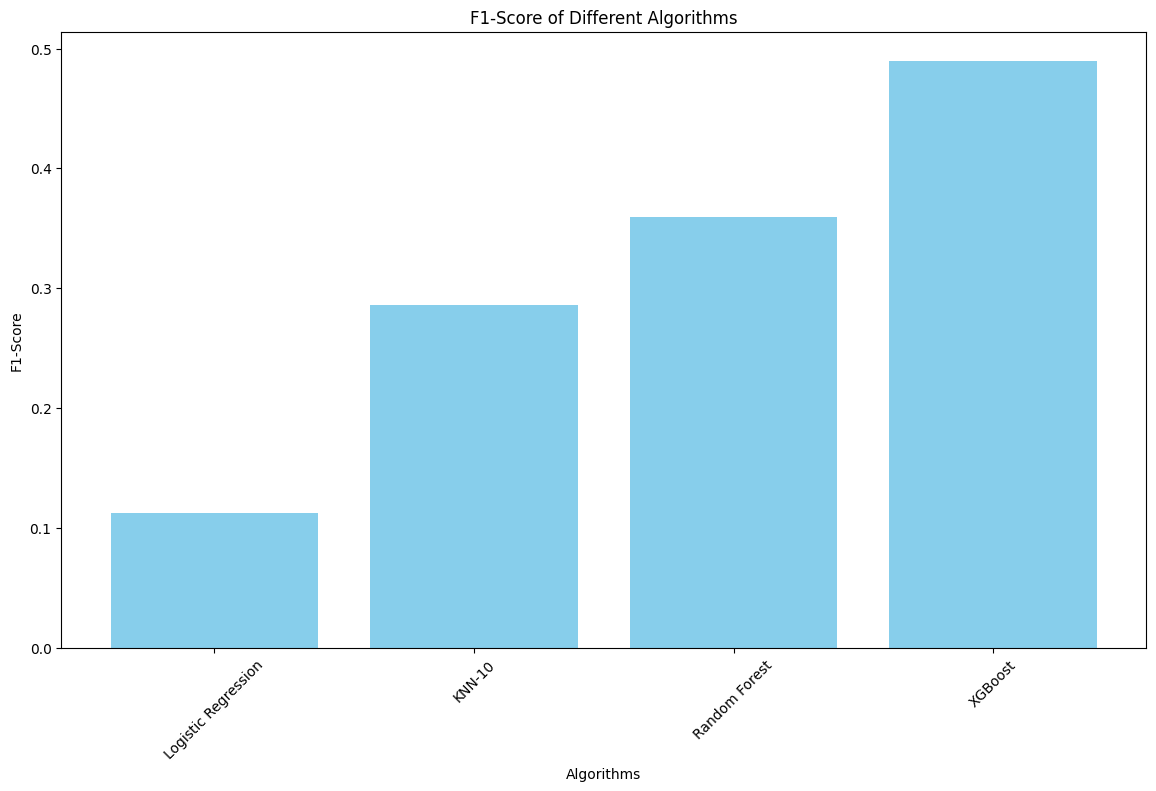

In [48]:
# Visualize F1 Scores
algos = ['Logistic Regression', 'KNN-10', 'Random Forest', 'XGBoost']
f1_scores = [f1_log_reg, f1_knn, f1_rf, f1_xgb]

plt.figure(figsize=(14, 8))
plt.bar(algos, f1_scores, color='skyblue')
plt.title('F1-Score of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.show()